In [1]:
!pip install tflite_model_maker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 577 kB 12.9 MB/s 
     |████████████████████████████████| 128 kB 66.7 MB/s 
     |████████████████████████████████| 238 kB 19.4 MB/s 
     |████████████████████████████████| 10.9 MB 33.4 MB/s 
     |████████████████████████████████| 87 kB 8.3 MB/s 
     |████████████████████████████████| 3.4 MB 47.8 MB/s 
     |████████████████████████████████| 840 kB 33.5 MB/s 
     |████████████████████████████████| 1.1 MB 24.7 MB/s 
     |████████████████████████████████| 77 kB 6.8 MB/s 
     |████████████████████████████████| 60.2 MB 1.5 MB/s 
     |████████████████████████████████| 1.3 MB 48.4 MB/s 
     |████████████████████████████████| 25.3 MB 1.8 MB/s 
     |████████████████████████████████| 497.9 MB 34 kB/s 
     |████████████████████████████████| 352 kB 68.6 MB/s 
     |████████████████████████████████| 5.8 MB 46.6 MB/s 
     |████████████████████████████

In [2]:
import os
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2')
from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader
from tflite_model_maker.image_classifier import ModelSpec
import matplotlib.pyplot as plt


In [3]:
!sudo apt-get install libportaudio2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 4 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 0s (1,137 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [5]:
!mkdir kaggle
!cp /content/kaggle.json kaggle/kaggle.json

In [6]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/kaggle"

if os.path.exists("/content/road-sign-detection.zip"):
  print("road-sign-dataset exists")
else:
  !kaggle datasets download -d andrewmvd/road-sign-detection
  !unzip road-sign-detection.zip

 99% 216M/218M [00:03<00:00, 75.8MB/s]
100% 218M/218M [00:03<00:00, 68.1MB/s]
Archive:  road-sign-detection.zip
  inflating: annotations/road0.xml   
  inflating: annotations/road1.xml   
  inflating: annotations/road10.xml  
  inflating: annotations/road100.xml  
  inflating: annotations/road101.xml  
  inflating: annotations/road102.xml  
  inflating: annotations/road103.xml  
  inflating: annotations/road104.xml  
  inflating: annotations/road105.xml  
  inflating: annotations/road106.xml  
  inflating: annotations/road107.xml  
  inflating: annotations/road108.xml  
  inflating: annotations/road109.xml  
  inflating: annotations/road11.xml  
  inflating: annotations/road110.xml  
  inflating: annotations/road111.xml  
  inflating: annotations/road112.xml  
  inflating: annotations/road113.xml  
  inflating: annotations/road114.xml  
  inflating: annotations/road115.xml  
  inflating: annotations/road116.xml  
  inflating: annotations/road117.xml  
  inflating: annotations/road118.x

In [ ]:
import glob
import pandas as pd

def mkdir(path):
  if os.path.exists(path):
    pass
  else:
    os.mkdir(path)

In [ ]:
#organize images folder
for file in glob.glob('/content/annotations/*'):
  df = pd.read_xml(file)
  name = df.iloc[4]['name'] 
  filename = df.iloc[1]['filename']
  mkdir(f'images/{name}')  
  os.rename(f'images/{filename}', f'images/{name}/{filename}')
  print(filename, name)


road625.png speedlimit
road669.png crosswalk
road504.png speedlimit
road394.png speedlimit
road496.png speedlimit
road79.png stop
road105.png speedlimit
road344.png speedlimit
road162.png speedlimit
road43.png trafficlight
road863.png speedlimit
road659.png speedlimit
road405.png speedlimit
road590.png speedlimit
road422.png speedlimit
road859.png speedlimit
road398.png speedlimit
road224.png speedlimit
road355.png speedlimit
road280.png speedlimit
road164.png trafficlight
road462.png crosswalk
road643.png speedlimit
road836.png speedlimit
road147.png crosswalk
road417.png speedlimit
road190.png crosswalk
road219.png speedlimit
road681.png speedlimit
road757.png speedlimit
road702.png speedlimit
road230.png speedlimit
road500.png speedlimit
road872.png speedlimit
road684.png speedlimit
road598.png crosswalk
road792.png speedlimit
road622.png speedlimit
road397.png speedlimit
road149.png crosswalk
road209.png speedlimit
road425.png speedlimit
road705.png speedlimit
road709.png speedlimi

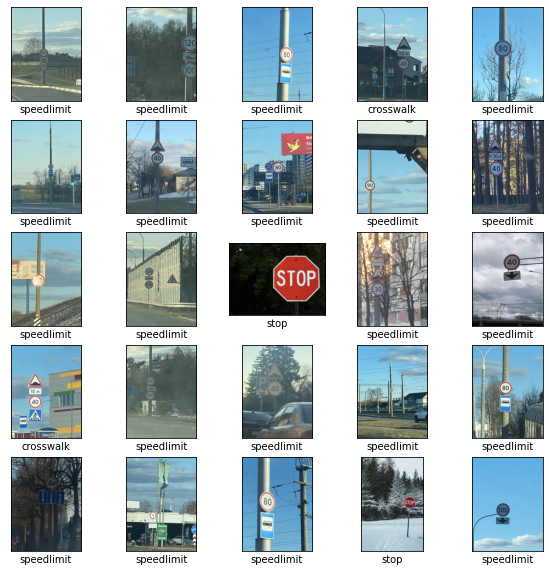

In [ ]:
data = DataLoader.from_folder('/content/images/')
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False) 
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()


In [ ]:
train_data, test_data = data.split(0.90)
model = image_classifier.create(train_data)
loss, accuracy = model.evaluate(test_data)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 3,418,148
Trainable params: 5,124
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/5
24/24 [==============================] - 16s 228ms/step - loss: 0.9042 - accuracy: 0.7513
Epoch 2/5
24/24 [==============================] - 6s 262ms/step - loss: 0.6282 - accuracy: 0.8815
Epoch 3/5
24/24 [===================

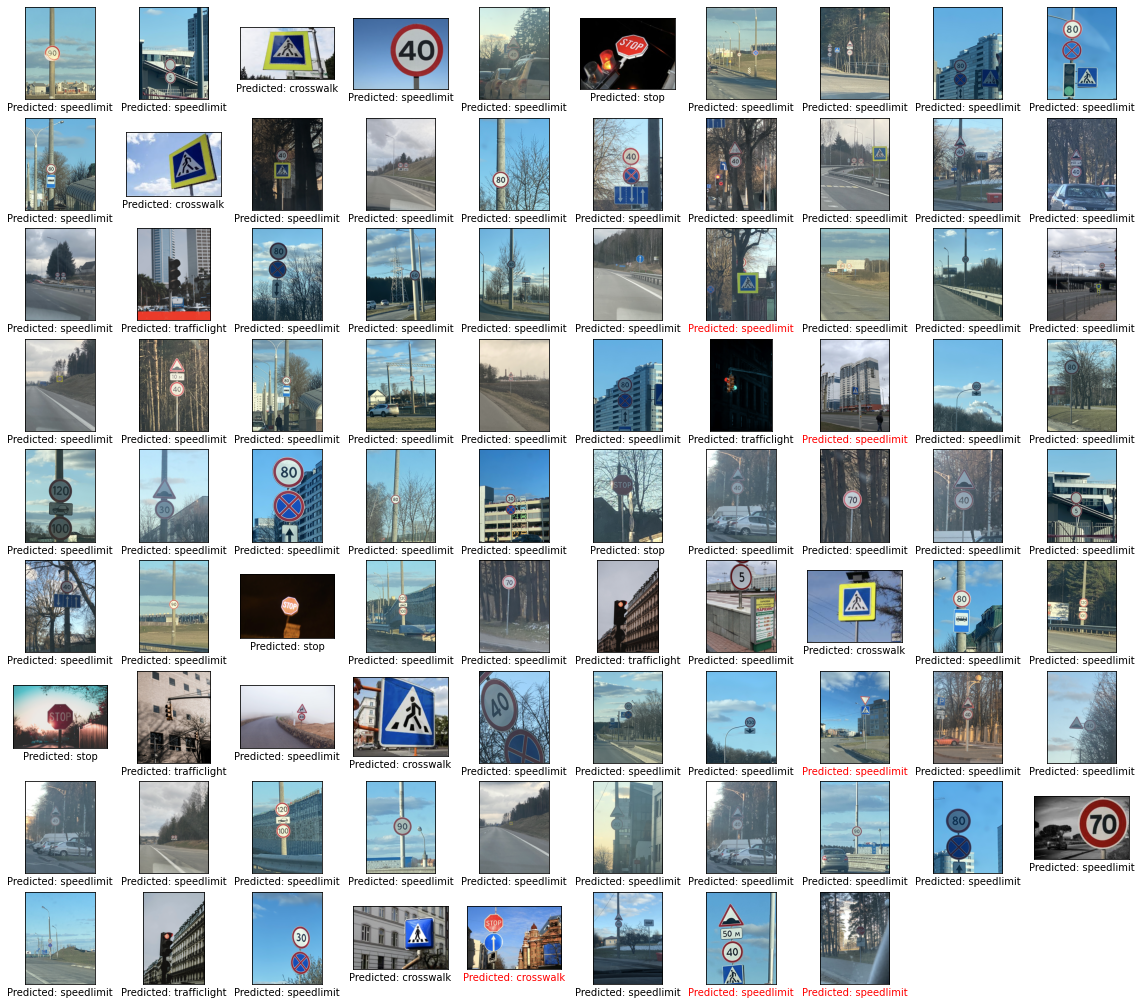

In [ ]:
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

plt.figure(figsize=(20, 20))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label, test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

In [ ]:
model.export(export_dir='.')
model.export(export_dir='.', export_format=ExportFormat.LABEL)

/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
from keras.preprocessing import image
import tensorflow as tf
import numpy as np

def load_tflite_model(model_path): 
  tflite_interpreter = tf.lite.Interpreter(model_path=model_path)
  tflite_interpreter.allocate_tensors()

  input_details = tflite_interpreter.get_input_details()
  output_details = tflite_interpreter.get_output_details()
  
  return tflite_interpreter, input_details, output_details

def load_labels(label_path):
  with open(label_path, 'r') as f:
      labels = list(map(str.strip, f.readlines()))
  return labels

def load_image(image_path):
  img = image.load_img(image_path,target_size=(224,224))
  img_array = tf.keras.utils.img_to_array(img)
  img = tf.expand_dims(img_array, 0)
  img = np.array(img, dtype=np.uint8)
  return img

def predict(model_path, label_path, img_path):
  tflite_interpreter, input_details, output_details = load_tflite_model(model_path)
  labels = load_labels(label_path)
  img = load_image(img_path)
  top_k_results= len(labels)
  tflite_interpreter.set_tensor(input_details[0]['index'], img)
  tflite_interpreter.invoke()
  predictions = tflite_interpreter.get_tensor(output_details[0]['index'])[0]
  top_k_indices = np.argsort(predictions)[::-1][:top_k_results]
  print(top_k_indices)
  for i in range(top_k_results):
    print("{:20}: {}%".format(
        labels[top_k_indices[i]],
        int((predictions[top_k_indices[i]] / 255.0) * 100)))
  pred_max=predictions[top_k_indices[0]]/255.0
  lbl_max=labels[top_k_indices[0]]
  return pred_max, lbl_max

[2 0 1 3]
stop                : 85%
crosswalk           : 7%
speedlimit          : 5%
trafficlight        : 1%
pred: conf: 0.8509803921568627 - label: stop


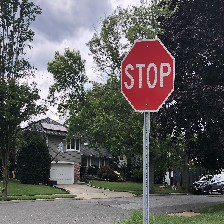

In [ ]:
model_path = "/content/model.tflite"
label_path = "/content/labels.txt"
img_path = "/content/stop.jpg" 

pred_max, lbl_max = predict(model_path,label_path, img_path)
print('pred:', 'conf:', pred_max,'- label:', lbl_max)

img = image.load_img(img_path,target_size=(224,224))
display(img)
